setting up wave functions...
num points:  7680000
seconds:  4.0


interactive(children=(FloatSlider(value=2.28, description='phaseOffset', layout=Layout(width='100%'), max=6.28…

<function __main__.SampleAndPlot(phaseOffset, xFactor)>

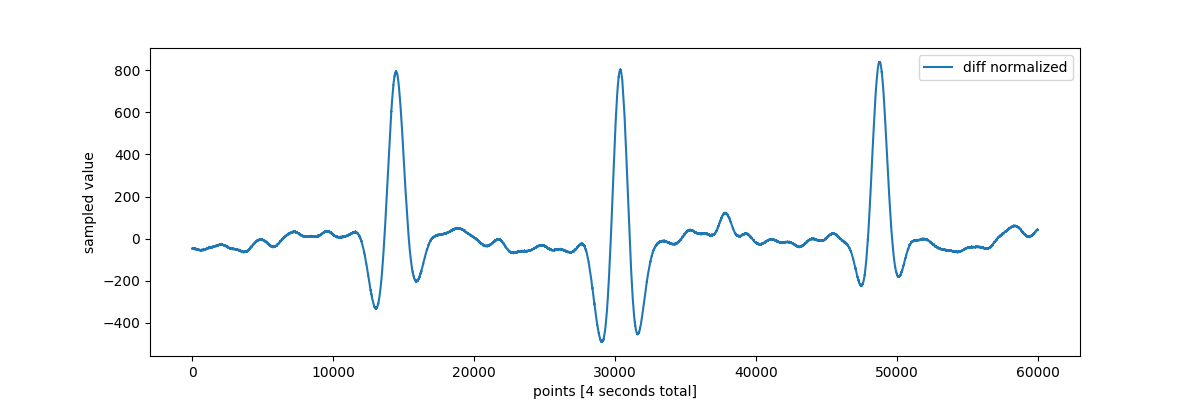

In [2]:
!python "wavefunctions.py"

from wavefunctions import GenerateSinewavePoints, GenerateSinewavePeriods

%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact, FloatSlider, IntSlider, Layout
import scipy.signal as signal

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

sampleRate = 192000
frequency = 16000

#filename = r"2022_02_25 17_57_52 MST 192000 SPS 16000.0 Hz 20 vol playing (air).txt"
#filename = r"2022_02_25 17_58_12 MST 192000 SPS 16000.0 Hz 20 vol playing (air then ground).txt"
filename = r"2022_02_25 17_58_33 MST 192000 SPS 16000.0 Hz 20 vol playing (quarter).txt"
#filename = r"2022_02_25 17_58_52 MST 192000 SPS 16000.0 Hz 20 vol playing (sword guard).txt"
#filename = r"2022_02_25 17_59_10 MST 192000 SPS 16000.0 Hz 20 vol playing (ground).txt"

signalData = pd.read_csv(filename, header=None).to_numpy()[:,0]
numPoints = signalData.shape[0]

#interpolate to get finer phase adjustments, and closer to the zero crossings
#TODO: interpolate surrounding points when sampling instead of all points?
signalData = np.interp(np.arange(0, numPoints, 0.1), np.arange(0, numPoints, 1), signalData)
sampleRate = sampleRate * 10
numPoints = signalData.shape[0]

print("num points: ", numPoints)
print("seconds: ", numPoints/sampleRate)

firFilter = signal.firwin(2001, cutoff = 500, window = "hamming", pass_zero = "lowpass", fs=sampleRate)

fig = plt.figure()
def SampleAndPlot(phaseOffset, xFactor):
    offsetInSamples = int(round(phaseOffset / (math.pi*2) * sampleRate * 1.0 / frequency, 0))
    print("offset in samples: ", offsetInSamples)
    
    periodInSamples = int(round(sampleRate * 1.0 / frequency, 0))
    quarterPeriodInSamples = int(round(math.pi/2 / (math.pi*2) * sampleRate * 1.0 / frequency, 0))
    
    signalXList = []
    for i in range(offsetInSamples, numPoints, periodInSamples): signalXList.append(signalData[i])
    signalX = np.asarray(signalXList)
    
    signalRList = []
    for i in range(offsetInSamples + quarterPeriodInSamples, numPoints, periodInSamples): signalRList.append(signalData[i])
    signalR = np.asarray(signalRList)
    
    #make arrays the same size
    if (signalR.size != signalX.size):
        minSize = min([signalR.size, signalX.size])
        signalR = signalR[0:minSize-1]
        signalX = signalX[0:minSize-1]
        
    
    signalX = signal.lfilter(firFilter, 1, signalX)
    signalR = signal.lfilter(firFilter, 1, signalR)
    
    signalX = signalX[2000:-1]
    signalR = signalR[2000:-1]
    
    diff = (signalR - (xFactor*signalX))
    diffSubset = diff[2000:-1]
    diffMagnitude = max(diffSubset) - min(diffSubset)
    print("diff min: ", min(diffSubset))
    print("diff max: ", max(diffSubset))
    print("diff magnitude: ", diffMagnitude)
    
    plt.clf()
    #plt.plot(signalX - np.mean(signalX), label="X normalized (mineral)")
    #plt.plot(signalR - np.mean(signalR), label="R normalized (metal)")
    plt.plot(-1 * (diffSubset- np.mean(diffSubset)), label="diff normalized")
    plt.xlabel('points [4 seconds total]')
    plt.ylabel('sampled value')
    plt.axis('tight')
    plt.legend()
    fig.canvas.draw()
    
    
interact(SampleAndPlot, 
         phaseOffset=FloatSlider(min=0, max=2*math.pi, step=0.001, value=2.28, layout=Layout(width='100%')),
         xFactor=FloatSlider(min=-20, max=20, step=0.01, value = -4, layout=Layout(width='100%'))
        )